In [1]:
# Practical 1: Feature Engineering and Selection (UCI Magic Gamma Telescope Dataset)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
magic_gamma_telescope = fetch_ucirepo(id=159) 
  
# data (as pandas dataframes) 
X = magic_gamma_telescope.data.features 
y = magic_gamma_telescope.data.targets 
  
# metadata 
print(magic_gamma_telescope.metadata) 
  
# variable information 
print(magic_gamma_telescope.variables) 


{'uci_id': 159, 'name': 'MAGIC Gamma Telescope', 'repository_url': 'https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope', 'data_url': 'https://archive.ics.uci.edu/static/public/159/data.csv', 'abstract': 'Data are MC generated to simulate registration of high energy gamma particles in an atmospheric Cherenkov telescope', 'area': 'Physics and Chemistry', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 19020, 'num_features': 10, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2004, 'last_updated': 'Tue Dec 19 2023', 'dataset_doi': '10.24432/C52C8B', 'creators': ['R. Bock'], 'intro_paper': None, 'additional_info': {'summary': "The data are MC generated (see below) to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamm

In [3]:
df = pd.concat([X, y], axis=1)
df['class'] = LabelEncoder().fit_transform(df['class'])
X = df.drop(columns=['class'])
y = df['class']
X.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620


In [4]:
scaler_minmax = MinMaxScaler()
X_minmax = pd.DataFrame(scaler_minmax.fit_transform(X), columns=X.columns)

scaler_std = StandardScaler()
X_std = pd.DataFrame(scaler_std.fit_transform(X), columns=X.columns)

print("\nScaled data preview:")
display(X_std.head())



Scaled data preview:


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,-0.577226,-0.336804,-0.381130,0.062759,-0.148923,0.541042,0.224818,-0.405842,0.476816,-1.497866
1,-0.510969,-0.570027,-0.648595,0.820383,1.471776,0.516919,0.260364,-0.490094,-0.815418,0.153125
2,2.568278,6.205858,2.615783,-1.875883,-1.773241,2.044992,-1.478536,-2.183030,1.889224,0.842635
3,-0.694768,-0.687259,-1.029478,1.282069,1.606608,0.532771,-0.333515,-0.355359,-0.658804,-1.031463
4,0.516622,0.476384,0.711157,-0.347506,-0.284660,-0.020200,0.353086,1.036620,-0.881039,2.176427


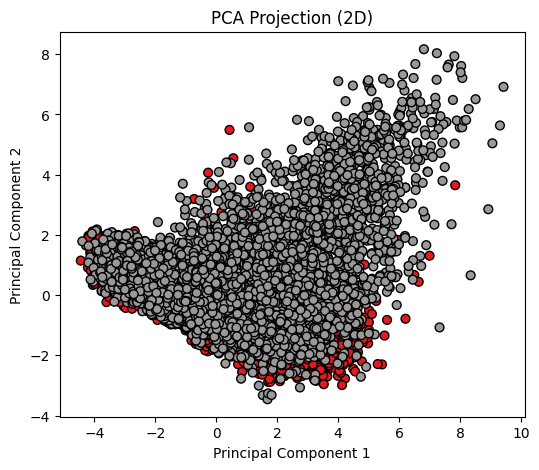

Variance captured by 2 components: 57.99%


In [11]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y,cmap='Set1', s=40, edgecolor='k')
plt.title("PCA Projection (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

explained_var = np.sum(pca.explained_variance_ratio_)
print(f"Variance captured by 2 components: {explained_var*100:.2f}%")

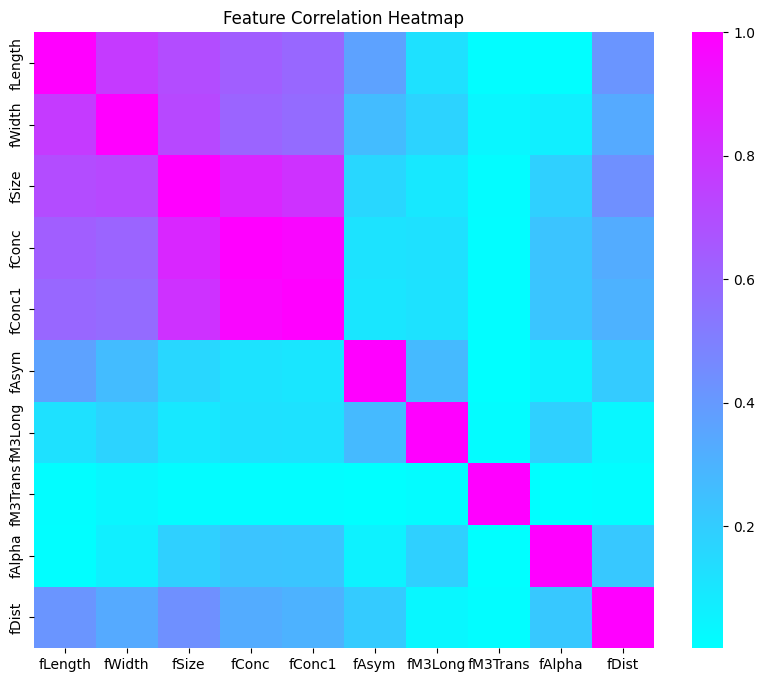

Highly correlated features: ['fConc1']
Shape after correlation filtering: (19020, 9)


In [8]:
corr_matrix = X.corr().abs()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='cool', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
print("Highly correlated features:", high_corr)

X_corr_filtered = X.drop(columns=high_corr)
print("Shape after correlation filtering:", X_corr_filtered.shape)


Top 8 features selected by Chi-square test:
 Index(['fLength', 'fWidth', 'fSize', 'fConc', 'fAsym', 'fM3Long', 'fAlpha',
       'fDist'],
      dtype='object')


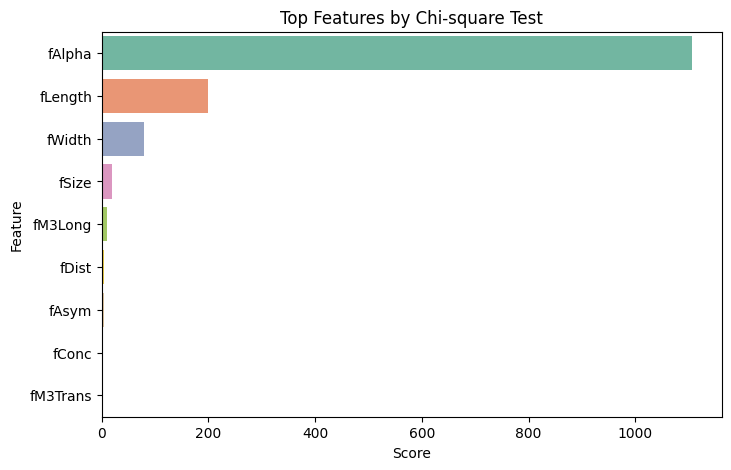

In [7]:
X_chi2 = MinMaxScaler().fit_transform(X_corr_filtered)
chi2_selector = SelectKBest(score_func=chi2, k=8)
X_best = chi2_selector.fit_transform(X_chi2, y)

selected_features = X_corr_filtered.columns[chi2_selector.get_support()]
print("\nTop 8 features selected by Chi-square test:\n", selected_features)

# Visualize Chi2 scores
chi2_scores = pd.DataFrame({
    "Feature": X_corr_filtered.columns,
    "Score": chi2_selector.scores_
}).sort_values(by="Score", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=chi2_scores.head(10), hue = "Feature", x="Score", y="Feature", palette="Set2")
plt.title("Top Features by Chi-square Test")
plt.show()
